In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-08-01 00:00:00"),
                  end=string2ts("2018-04-01 00:00:00"),
                  period=3600*4)
per = 0.85

from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())


In [17]:
from mldata import ml_data
from orders import orders
from profit import profit
from bot import marketReturn

df["ml_data"] = ml_data(df["close"],la=10, pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"], "log_return":marketReturn(df["close"])})

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

train.tail(3)

Retorno de estrategia ideal: 42647.6566934


,cci,close,dma,ideal_w,kdjd,kdjj,kdjk,log_return,macd,macds,price,pricew,rsi,trix,volatility,volumen,vr,wr
date,,,,,,,,,,,,,,,,,,
2018-02-23 03:00:00,214.267185,0.000095,-0.000009,1.0,53.732931,113.056990,73.507618,0.634113,-0.000002,-0.000003,0.000095,0.000094,50.894320,-0.465825,True,295.864605,40.239586,2.253521
2018-02-23 07:00:00,128.038925,0.000092,-0.000009,1.0,58.545869,87.423497,68.171745,0.585970,-0.000002,-0.000003,0.000092,0.000094,42.384229,-0.420827,True,213.864737,39.166339,42.500000
2018-02-23 11:00:00,92.242809,0.000093,-0.000008,0.0,61.726153,80.807852,68.086719,0.598865,-0.000002,-0.000003,0.000093,0.000093,45.035389,-0.375472,False,706.965509,53.269528,32.083333


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

features = ["log_return","rsi","cci","macds","macd","wr","trix","vr"]

X, y = data[features], data["ideal_w"]
X_train, y_train, X_test, y_test = train[features], train["ideal_w"], test[features], test["ideal_w"]

## Usando paquete Mlxtend

In [19]:
from mlxtend.classifier import EnsembleVoteClassifier


clf1 = RandomForestClassifier(n_estimators=45, max_depth=4, min_samples_split=65)
clf2 = DecisionTreeClassifier(max_depth=3, min_samples_split=250, min_samples_leaf=145)
clf3 = XGBClassifier(n_estimators=9, learning_rate=0.75, gamma=12)
clf4 = SVC(probability=True)
clf5 = LogisticRegression(C=0.150)
clf6 = AdaBoostClassifier(n_estimators=45, learning_rate=0.1)
clf7 = KNeighborsClassifier(n_neighbors=218, weights="distance")
eclf = EnsembleVoteClassifier(clfs=[clf1, clf3, clf4, clf7], weights=[1, 1, 1, 1], voting='soft')

predictions = []

for clf, lab in zip([clf1, clf3, clf4, clf7, eclf],
              ['Random Forest', 'XGB', 'SVC', "knn", 'Ensemble']):
    clf.fit(X_train, y_train)
    pre = clf.predict(X_test)
    predictions.append(pre)
    print lab, accuracy_score(test["ideal_w"], pre)


Random Forest 0.730593607306
XGB 0.730593607306
SVC 0.616438356164
knn 0.744292237443
Ensemble 0.721461187215


Retorno de stacking_ensembling: -12.3745488568


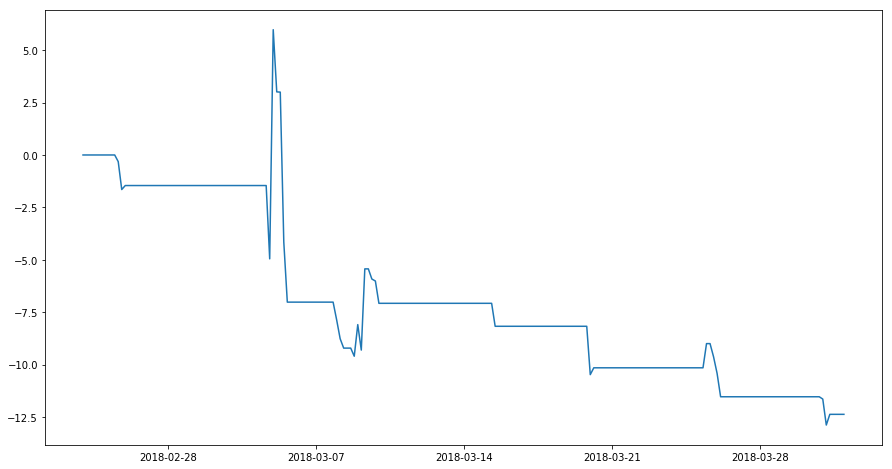

In [20]:
w10 = pd.DataFrame(data={"w":predictions[-1],"price":test["close"]})
w10["orders"] = orders(w10["w"])
w10["w"] = w10["w"].shift(1)
relativeReturn10, v10 = profit(w10)

print 'Retorno de stacking_ensembling: %s'%(relativeReturn10*100)

plt.plot(df.index[int(len(data)*per):],v10*100,label='retorno stacking')

## Usando paquete vecstack

In [21]:
from vecstack import stacking

models = [clf1,  clf4, clf7]

### Creando stacking

In [22]:
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=1)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    ----
    MEAN:     [0.81018538] + [0.01959245]
    FULL:     [0.81017771]

model  1:     [SVC]
    ----
    MEAN:     [0.62439254] + [0.00269838]
    FULL:     [0.62439418]

model  2:     [KNeighborsClassifier]
    ----
    MEAN:     [0.78353582] + [0.01159003]
    FULL:     [0.78352181]



### Aplicando modelo de 2 nivel

In [23]:
# Fit 2nd level model
model = clf3.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.75799087]
